In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests as r
import openpyxl
from io import BytesIO
import datetime
import mpl_axes_aligner
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [2]:
def auth_google():
    gauth = GoogleAuth()
    gauth.LoadCredentialsFile("credentials.json")
    if gauth.credentials is None: 
        gauth.LocalWebserverAuth()
        gauth.SaveCredentialsFile("credentials.json")
    elif gauth.access_token_expired: 
        gauth.Refresh()
    else: 
        gauth.Authorize()
    drive = GoogleDrive(gauth)
    
    return drive
drive = auth_google()

In [43]:
def read_files(drive): 
    folderID = '1JcFXUagRISwGaVHmmTzyJiXodLPSjaGhcuzkT7G_8EPdr5KvS2E8Baid7GWcd8S4B-HBE_kG'
    file_list = drive.ListFile({'q': f"'{folderID}' in parents and trashed=false"}).GetList()
    
    tags = ['title', 'webContentLink', 'fileExtension']
    
    file_tags = [{tag: file[tag] for tag in tags} for file in file_list]

    return file_tags
file_tags = read_files(drive)

In [44]:
file_tags

[GoogleDriveFile({'kind': 'drive#file', 'userPermission': {'id': 'me', 'type': 'user', 'role': 'owner', 'kind': 'drive#permission', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW/permissions/me', 'etag': '"jifUC_cBFCVJRgYeNhpIJh5Lvzo"', 'pendingOwner': False}, 'fileExtension': 'xlsx', 'md5Checksum': 'be5d8d319b139573ca9b59328825185e', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW', 'ownerNames': ['flowdata viz'], 'lastModifyingUserName': 'adamski.nicholas', 'editable': True, 'writersCanShare': True, 'downloadUrl': 'https://www.googleapis.com/drive/v2/files/1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW?alt=media&source=downloadUrl', 'mimeType': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'parents': [{'selfLink': 'https://www.googleapis.com/drive/v2/files/1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW/parents/1JcFXUagRISwGaVHmmTzyJiXodLPSjaGhcuzkT7G_8EPdr5KvS2E8Baid7GWcd8S4B-HBE_kG', 'id': '1JcFXUagRISwG

In [39]:
start_time = time.time()


response = r.get('https://drive.google.com/uc?id=1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW&export=download')

excel_file = pd.ExcelFile(BytesIO(response.content))
df = pd.read_excel(test)

print(time.time() - start_time)


4.483521461486816


In [40]:
start_time = time.time()


response = r.get('https://drive.google.com/uc?id=1Pb0Bt4B5EdX2X2G_GJg3yiUdz23v-ECW&export=download')

excel_file = pd.ExcelFile(BytesIO(response.content))
df = excel_file.parse(sheet_name = excel_file.sheet_names[0])

print(time.time() - start_time)

3.2557766437530518


In [35]:
excel_file.sheet_names[0]

'STUP 11-17-2023 0.35 cfs'

In [16]:
sheet_id = '1mrbBkhl6TDZNPUTZkHOaRw6MqLU5VHyURoRnQNqZ7-M'
url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + sheet_id

file = r.get(url)
data = BytesIO(file.content)
xlsx = pd.ExcelFile(data)

In [17]:
flow_data = {}
meta_data = {}

for name in xlsx.sheet_names:
    if name == 'Summary': 
        continue
    if '!' in name: 
        continue
    flow_data[name] = pd.read_excel(data, sheet_name = name, usecols='A:F', skiprows=12)
    meta_data[name] = pd.read_excel(data, sheet_name = name, nrows = 12, header=None)

In [18]:
class Measurement(): 
    
    
    
    def __init__(self, name):
        self.name = name
        
        table_schema = {'station': [0, 3], 
                'coordinates': [0, 6], 
                'site_code': [0, 13],
                'date': [2, 2], 
                'start_time': [2, 4],
                'end_time': [3, 4],
                'timezone': [2, 5], 
                'meter_type': [2, 13],
                'crew': [4, 1, [4, 2]]}
        
        self.flow_data = flow_data[name].dropna()
        self.discharge = self.flow_data['Dis-charge, ft3/s'].sum()
        self.area = self.flow_data['Area, ft2'].sum()
        self.average_velocity = self.discharge / self.area
        self.max_observed_depth = self.flow_data['Depth'].max()
        
        
        self.meta_table = meta_data[name]
        for variable, coord in table_schema.items(): 
            self.__dict__[variable] = self.meta_table.iloc[coord[0], coord[1]]
            
            if pd.isnull(self.__dict__[variable]) and coord[2:]: 
                #If there is a backup location listed, use that instead. 
                self.__dict__[variable] = self.meta_table.iloc[coord[2][0], coord[2][1]]
        if pd.isnull(self.site_code): 
            self.site_code = self.name.split(' ')[0]
        print(name)
        self.crew = self.crew.split(', ')
        
        
list_measurements = [Measurement(name) for name in flow_data.keys()]
list_dates = sorted(list(set([measurement.date for measurement in list_measurements])))
sites = list(set([measurement.site_code for measurement in list_measurements]))

STUP 11-17-2023 0.35 cfs
STUP 10-27-2023 0.36cfs
Unnamed 11-3-2023 0.2cfs
Unnamed 10-27-2023 0.21cfs
STWB 11-17-2023 0.47 cfs
STWB 11-3-2023 0.48cfs
STWB 10-27-2023 0.71cfs


In [26]:
def plotmany(location, dates, variables, l_axis=False, r_axis=False): 
    fig, ax1 = plt.subplots()
    
    l_axis = l_axis or variables[0]
    variables.remove(l_axis)
    variables.insert(0, l_axis)
    
    if len(variables) > 1: 
        r_axis = r_axis or variables[1]
        variables.remove(r_axis)
        variables.insert(1, r_axis)
    
    data = [measure for measure in list_measurements if (measure.date in dates and measure.site_code == location)]
    data = sorted(data, key = lambda x: x.date, reverse=True)
    
    alpha = 1
    for measure in data: 
        measure.alpha = alpha
        alpha = alpha - 1/(len(dates))
    
    ylabels = {'Depth': 'DEPTH, IN FEET', 'Velocity': 'VELOCITY, IN FT/S', 'Discharge': 'DISCHARGE, CFS'}
    col_names = {'Depth': 'Depth', 'Velocity': 'V', 'Discharge': 'Dis-charge, ft3/s'}
    color_dict = {'Depth': 'k', 'Velocity': 'C0', 'Discharge': 'C1'}
    xlabel = 'DISTANCE ALONG SECTION, IN FEET'
    
    color = color_dict[l_axis]
    ax1.set_ylabel(ylabels[l_axis], color=color)
    ax1.set_xlabel(xlabel)
    ax1.tick_params(axis='y', labelcolor=color)
    
    for measure in data: 
        ax1.plot(measure.flow_data['Dist. From initial point'], measure.flow_data[col_names[variables[0]]], alpha=measure.alpha, color=color)
        
    if r_axis: 
        ax2 = ax1.twinx()
        color = color_dict[r_axis]
        ax2.set_ylabel(ylabels[r_axis], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        for measure in data: 
            ax2.plot(measure.flow_data['Dist. From initial point'],measure.flow_data[col_names[variables[1]]], alpha=measure.alpha, color=color)
        mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    
    if len(variables) == 3: 
        ax3 = ax1.twinx()
        color = color_dict[variables[2]]
        ax3.spines.right.set_position(('axes', 1.2))
        ax3.tick_params(axis='y', labelcolor=color)
        ax3.set_ylabel(ylabels[variables[2]], color=color)


        for measure in data:
            ax3.plot(measure.flow_data['Dist. From initial point'],measure.flow_data[col_names[variables[2]]], alpha=measure.alpha, color=color)
        mpl_axes_aligner.align.yaxes(ax1, 0, ax3, 0, 0.1)
    
    
    
    
    fig.tight_layout()
    plt.show()
    

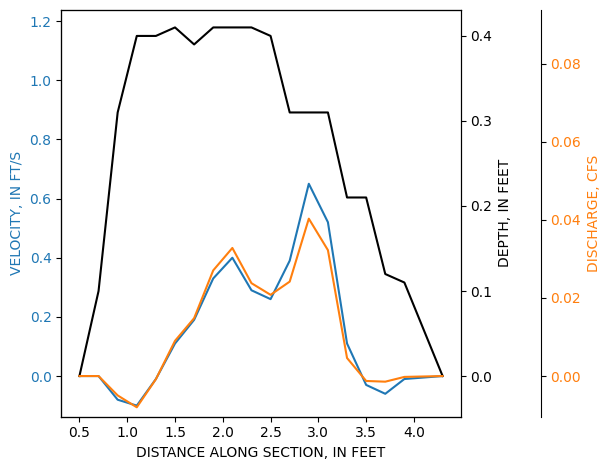

In [27]:
plotmany('Unnamed', [datetime.datetime(2023, 11, 17, 0, 0), datetime.datetime(2023, 10, 27, 0, 0)], ['Velocity', 'Depth', 'Discharge'])

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



def f(location, dates, variables): 
    return plotmany(location, dates, list(variables))

interact(f, 
         location = sites,
         dates = widgets.SelectMultiple(
                options = [(date.strftime('%d/%m/%Y'), date) for date in list_dates], 
                values = [list_dates[0]], 
                description = 'Dates'),
         variables = widgets.SelectMultiple(
                options = ['Depth', 'Velocity', 'Discharge'], 
                value = ['Depth'],
                description = 'Variables'))

In [ ]:
import io


url_base = 'https://wr.slocountywater.org/export/file/'

args = {'site_id': '29', 
        'site' : '5952eafd-17d9-4cb6-a6dd-c949a99525f0', 
        'device_id': '1',
        'device': '1c308219-4b72-4307-a5c0-76ed02cdba41',
        'mode' : '',
        'hours' : '',
        'data_start' : datetime.datetime(2024, 9, 1, 0, 0).strftime('%Y-%m-%d %H:%M:%S'),
        'data_end' : datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'tz' : 'US%2FPacific',
        'format_datetime' : '%25Y-%25m-%25d+%25H%3A%25i%3A%25S',
        'mime' : 'txt',
        'delimiter' : 'comma'}

url = url_base + '?' + '&'.join(['='.join([key, value]) for key, value in args.items()])

response = r.get(url)


csv_data = io.StringIO(response.text)
df = pd.read_csv(csv_data)

In [184]:
statistics = [[measure.site_code,
               measure.date.date(),
               measure.max_observed_depth, 
               measure.max_observed_depth/(measure.flow_data.iloc[-1,0]-measure.flow_data.iloc[0,0]),
               measure.discharge, 
               measure.average_velocity] for measure in list_measurements]


statistics = pd.DataFrame(statistics)
statistics.columns = ['Location', 'Date', 'Max Depth (ft)', 'Avg Depth (ft)', 'Total Discharge (CFS)', 'Average Velocity (ft/s)']
statistics = statistics.round(2).sort_values(['Location', 'Date']).set_index(['Location', 'Date'])

diff = (statistics - statistics.shift(1)).groupby('Location').apply(lambda group: group.iloc[1:, :])
diff.index = diff.index.droplevel(0)
diff['delta'] = True
statistics['delta']=False

joined = pd.concat([statistics, diff],axis = 0).sort_values(['Location', 'Date', 'delta'], ascending=[False, False, True]).reset_index()
joined

,Location,Date,Max Depth (ft),Avg Depth (ft),Total Discharge (CFS),Average Velocity (ft/s),delta
0,Unnamed,2023-11-03,0.40,0.11,0.20,0.20,False
1,Unnamed,2023-11-03,-0.01,0.00,-0.01,0.00,True
2,Unnamed,2023-10-27,0.41,0.11,0.21,0.20,False
3,STWB,2023-11-17,0.65,0.05,0.47,0.10,False
4,STWB,2023-11-17,-0.03,0.00,-0.01,0.00,True
5,STWB,2023-11-03,0.68,0.05,0.48,0.10,False
6,STWB,2023-11-03,-0.02,-0.01,-0.23,-0.05,True
7,STWB,2023-10-27,0.70,0.06,0.71,0.15,False
8,STUP,2023-11-17,0.80,0.10,0.35,0.07,False
9,STUP,2023-11-17,-0.36,-0.02,-0.01,0.02,True


In [183]:
def color_red_green(val): 
    if val.delta: 
        return np.select([val < 0, val > 0, val == 0], ['background-color: salmon', 'background-color: palegreen', 'background-color: lightgray'])
    else: 
        return [""] * len(val)

joined.style.apply(color_red_green,subset=['Max Depth (ft)', 'Avg Depth (ft)', 'Total Discharge (CFS)', 'Average Velocity (ft/s)', 'delta'], axis=1).hide('delta', axis=1).hide(axis='index').format(precision=2)

Location,Date,Max Depth (ft),Avg Depth (ft),Total Discharge (CFS),Average Velocity (ft/s)
Unnamed,2023-11-03,0.40,0.11,0.20,0.20
Unnamed,2023-11-03,-0.01,0.00,-0.01,0.00
Unnamed,2023-10-27,0.41,0.11,0.21,0.20
STWB,2023-11-17,0.65,0.05,0.47,0.10
STWB,2023-11-17,-0.03,0.00,-0.01,0.00
STWB,2023-11-03,0.68,0.05,0.48,0.10
STWB,2023-11-03,-0.02,-0.01,-0.23,-0.05
STWB,2023-10-27,0.70,0.06,0.71,0.15
STUP,2023-11-17,0.80,0.10,0.35,0.07
STUP,2023-11-17,-0.36,-0.02,-0.01,0.02


In [188]:
statistics.delta\
          .sum()

0

In [3]:
import dash

In [5]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

app = Dash()
app.layout = [
    html.H1(children='Waterflow measurements', style = {'textAlign': 'center'}), 
    dcc.Dropdown()
]

In [6]:
['']*6

['', '', '', '', '', '']

In [11]:
statistics = pd.DataFrame(columns = ['Location', 'Date', 'Max Depth (ft)', 'Avg Depth (ft)', 
                          'Total Discharge (CFS)', 'Average Velocity (ft/s)'])

statistics

,Location,Date,Max Depth (ft),Avg Depth (ft),Total Discharge (CFS),Average Velocity (ft/s)


NameError: name 'flow_data' is not defined

In [25]:
list_measurements[0].flow_data['Dist. From initial point']

0      1.5
1     1.51
2      1.9
3      2.3
4      2.7
5      3.1
6      3.5
7      3.9
8      4.3
9      4.7
10     5.1
11     5.5
12     5.9
13     6.3
14     6.7
15     7.1
16     7.5
17     7.9
18     8.3
19     8.7
20     9.1
21     9.5
22     9.8
Name: Dist. From initial point, dtype: object

NameError: name 'measurements' is not defined

In [9]:
class A(): 
    b = [1]
    def __init__(self): 
        self.a = self.b

In [13]:
B = A()
B.b

[1]